In [47]:
%load_ext autoreload
%autoreload 2

from stack_overflow_survey import StackOverflowSurvey

from scipy import stats
import statsmodels.stats.multitest;
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import RangeSlider

import os

if 'changed_dir' not in locals():
    changed_dir = True
    current_dir = os.getcwd()
    os.chdir("../")
    print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
survey_data = StackOverflowSurvey()
merged_df, age_mapping = survey_data.get_first_coding_age_data(2021)

merged_df.head()

,Alpha-2 code,5 - 10 years,18 - 24 years,11 - 17 years,25 - 34 years,55 - 64 years,35 - 44 years,Younger than 5 years,45 - 54 years,Older than 64 years,Country,Alpha-3 code,year,CP_EUR_HAB,samples
3,AL,0.114286,0.328571,0.400000,0.071429,0.000000,0.042857,0.028571,0.000000,0.014286,Albania,ALB,2021,5490.0,70.0
7,AT,0.114002,0.122677,0.675341,0.050805,0.004957,0.018587,0.003717,0.008674,0.001239,Austria,AUT,2021,45370.0,807.0
13,BE,0.103300,0.180775,0.639885,0.040172,0.002869,0.017217,0.004304,0.011478,0.000000,Belgium,BEL,2021,43330.0,697.0
15,BG,0.062189,0.213930,0.594527,0.097015,0.002488,0.017413,0.004975,0.004975,0.002488,Bulgaria,BGR,2021,10330.0,402.0
30,CH,0.131379,0.117264,0.671010,0.032573,0.003257,0.028230,0.004343,0.010858,0.001086,Switzerland,CHE,2021,77750.0,921.0


Correlation found with 55 - 64 years, pvalue=0.0087, cor_coeff=0.5477, 18.20689655172414
Correlation found with 55 - 64 years, pvalue=0.0087, cor_coeff=0.5477, 35.41379310344828


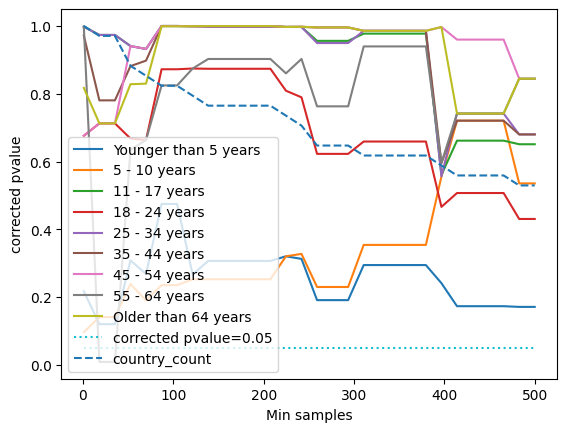

In [118]:
# We test for (non)-correlation via the Pearson correlation coefficient.
pval_evolution = []
country_count = []
ks = np.linspace(1.0, 500.0, 30)
for k in ks:
    filt_df = merged_df[merged_df["samples"] > k]
    country_count.append(len(filt_df))
    pvals = []
    correlation = []
    for col, age in age_mapping:
        res = stats.pearsonr(filt_df[col], filt_df["CP_EUR_HAB"])
        pvals.append(res.pvalue)
        correlation.append(res.statistic)

    reject, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(pvals, alpha=0.05)
    for i, (r, p) in enumerate(zip(reject, pvals_corrected)):
        if not r:
            continue
        print(f"Correlation found with {age_mapping[i][0]}, pvalue={p:.4f}, cor_coeff={correlation[i]:.4f}, {k}")

    pval_evolution.append(pvals_corrected)

for i in range(len(pval_evolution[0])):
    plt.plot(ks, [pval_evolution[k][i] for k in range(len(pval_evolution))], label=age_mapping[i][0])
plt.plot(ks, [0.05]*len(ks), linestyle='dotted', label='corrected pvalue=0.05')
plt.plot(ks, np.array(country_count)/np.max(country_count), linestyle='dashed', label='country_count')
plt.legend()
plt.ylabel("corrected pvalue")
plt.xlabel("Min samples")
plt.show()

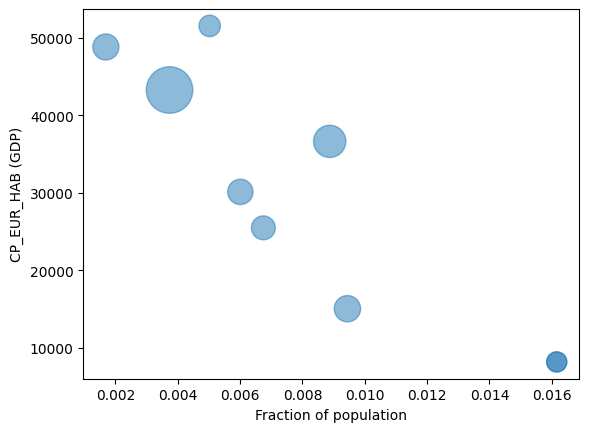

In [115]:
# Visually show this correlation by looking at a 
%matplotlib inline

filt_df = merged_df[merged_df["samples"] > 947]

# Plot average age in relation to CP_EUR_HAB (GDP)
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(filt_df["Younger than 5 years"], filt_df["CP_EUR_HAB"], s=filt_df["samples"]/5, alpha=0.5)
ax.set_xlabel("Fraction of population")
ax.set_ylabel("CP_EUR_HAB (GDP)")
plt.show()

In [8]:
# Plot the age density, with a slider filter for gdp
# The correlation found above is visible, but not as clear as above

%matplotlib notebook

x_min = 0
x_max = 30

fig = plt.figure()
ax = fig.add_subplot()
x = np.array([age for col, age in age_mapping])
lines = []
for index, row in merged_df.iterrows():
    y = [0.0]*len(x)
    for idx, (col, age) in enumerate(age_mapping):
        y[idx] += row[col]
    line, = ax.plot(x, y)
    lines.append((line, row["CP_EUR_HAB"]))

ax.set_xlim([x_min, x_max])
ax.set_xlabel("age")
ax.set_ylabel("density")

slider_ax = fig.add_axes([0.20, 0.9, 0.5, 0.02])
slider = RangeSlider(slider_ax, "GDP", merged_df["CP_EUR_HAB"].min(), merged_df["CP_EUR_HAB"].max())
def update(val):
    x_lb, x_ub = slider.val
    for line, gdp in lines:
        line.set_visible(gdp >= x_lb and gdp <= x_ub)
    fig.canvas.draw_idle()
    
slider.on_changed(update)
plt.show()

<IPython.core.display.Javascript object>